# House Price Prediction

inspiration:
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

read this: 
- https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
- https://www.kaggle.com/dansbecker/handling-missing-values
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

1. Тщательный анализ данных.
- Исследовать данные на наличие пропусков и некорректных значений. Либо удалить их, либо сделать imputing (проинтерполировать).
- Посмотреть на распределение целевой переменной. Идентифицировать аномалии. Решить, что делать: убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса). 
- Проанализировать признаки. Отобрать те, которые лично вам кажутся наиболее важными. Посмотреть на их распределение (в том числе на попарные). 
- Посмотреть на совместное распределение целевой переменной и выбранных признаков. 
- Сформулировать гипотезы о том, какие сочетания признаков могут быть полезны. Добавить их (если придумаете). Подсказка: отрисуйте выборку на карте, посчитайте расстояние до важных объектов в этом городе, посчитайте статистики по районам и по ближайшим объектам (не забудьте, что эти статистики нужно считать по обучающей выборке!).

In [1]:
!conda install pytz -y

Solving environment: done

# All requested packages already installed.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [44]:
train = pd.read_csv('../data/train.csv', index_col='Id')

In [45]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [46]:
test = pd.read_csv('../data/test.csv', index_col='Id')

In [47]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Handle null values

In [48]:
# show portion of null values
total_null = train.isnull().sum().sort_values(ascending=False)
percentage = total_null / train.loc[:, total_null.index].isnull().count()

percentage.name = 'Percentage of null values'
pd.DataFrame(percentage).head(20)

,Percentage of null values
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageType,0.055479
GarageCond,0.055479
GarageFinish,0.055479
GarageQual,0.055479


In [49]:
# these features contain more than 15% of null values
# and does not seem to be crucial
redundant_feat = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

train.drop(columns=redundant_feat, inplace=True)
test.drop(columns=redundant_feat, inplace=True)

In [50]:
# still we have some null values to consider
total_null = train.isnull().sum().sort_values(ascending=False)
percentage = total_null / train.loc[:, total_null.index].isnull().count()

percentage.name = 'Percentage of null values'
pd.DataFrame(percentage).head(20)

,Percentage of null values
GarageType,0.055479
GarageYrBlt,0.055479
GarageFinish,0.055479
GarageQual,0.055479
GarageCond,0.055479
BsmtFinType2,0.026027
BsmtExposure,0.026027
BsmtFinType1,0.025342
BsmtCond,0.025342
BsmtQual,0.025342


We will replace null values for numerical and categorical features separately.

Numerical features - replace null with mean\
Categorical features - replace null with mode

In [51]:
num_cols = train._get_numeric_data().columns.tolist()

In [52]:
cat_cols = set(train.columns) - set(num_cols)

In [53]:
# fill null values of numerical features with mean
for col in num_cols:
    if col == 'SalePrice':
        continue

    train[col].fillna(train[col].mean(), inplace=True)
    test[col].fillna(test[col].mean(), inplace=True)

In [54]:
# fill null values of categorical features with mode
for col in cat_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

In [55]:
# we handled all null values
print("Number of null values in train dataframe:", train.isna().sum().sum())
print("Number of null values in test dataframe:", test.isna().sum().sum())

Number of null values in train dataframe: 0
Number of null values in test dataframe: 0


## Find outliers

We can see that there two points that are not following the general trend. Points have big area(>4000) and low price(> 700000), that seems strange. We can remove those points to help our model to generalize better.

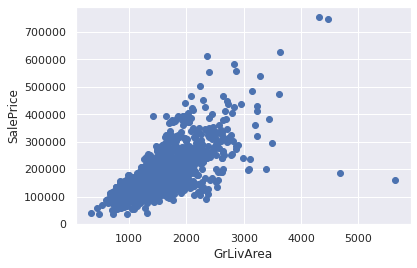

In [56]:
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [57]:
train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,0,10,2007,New,Partial,184750
1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,...,0,0,0,480,0,1,2008,New,Partial,160000


In [59]:
train.drop([524, 1299], inplace=True)

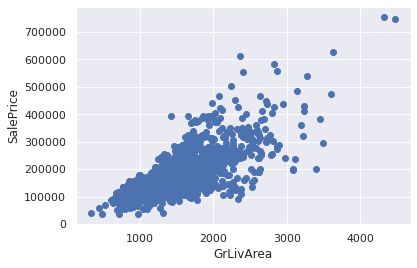

In [61]:
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

## Analyze features

Let us show the histogram of the target variable - SalePrice

As you can see the majority of houses have price greater than 100'000 and less than 300'000

But there are few houses which cost about 700'000

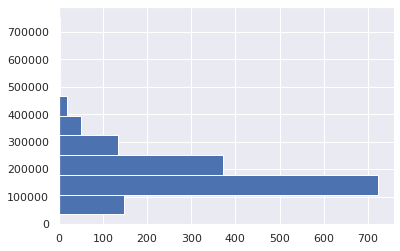

In [62]:
plt.hist(train['SalePrice'], orientation='horizontal')
plt.show()

Thankfully, pandas has a method describe which computes statistics for Series and DataFrames

We can observe that **mean** house price is ~181'000, the **min** is ~35'000 and **max** is ~755'000

Most interestingly, the **75%** of all houses in the dataset have **price below 214'000**

In [63]:
train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Easiest way to see whether there are correlations between features and target variable is to plot heatmap

In [64]:
corr = train.corr()
mask = np.zeros((len(corr), len(corr)))
# build nonzero upper triangle
for i in range(len(corr)):
    for j in range(len(corr)):
        if i > j:
            mask[i, j] = 1        

<AxesSubplot:>

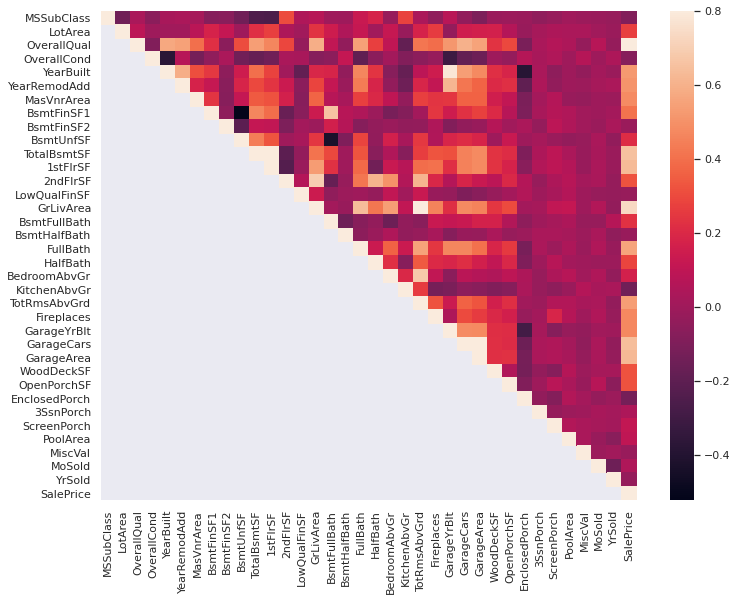

In [65]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=0.8, mask=mask)

Let us show mostly correlated features on the heatmap as it is quite difficult to observe 70+ feature

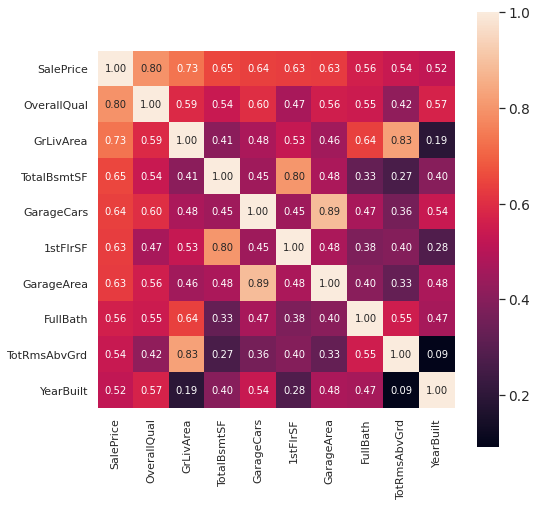

In [66]:
# saleprice correlation matrix
k = 10  # number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let us describe each feature in detail:
- OverallQual - Rates the overall material and finish of the house
- GrLivArea - Above grade (ground) living area square feet
- TotalBsmtSF - Total square feet of basement area 
- GarageCars - Size of garage in car capacity
- 1stFlrSF - First Floor square feet
- GarageArea - Size of garage in square feet
- FullBath - Full bathrooms above grade
- TotRmsAbvGrd - Total rooms above grade (does not include bathrooms)
- YearBuilt - Original construction date


--- 

- It seems that GarageArea and GarageCars are quite the same -> keep only GarageArea
- Quite the same relation as previous two have TotRmsAbvGrd and GrLivArea -> keep only GrLivArea
- And... 1stFlrSF with TotalBsmtSF -> keep only TotalBsmtSF


---

**Important!**
We will be considering those features as most important ones 

### Observe distributions of target and selected features

Let us plot pairplot of selected features

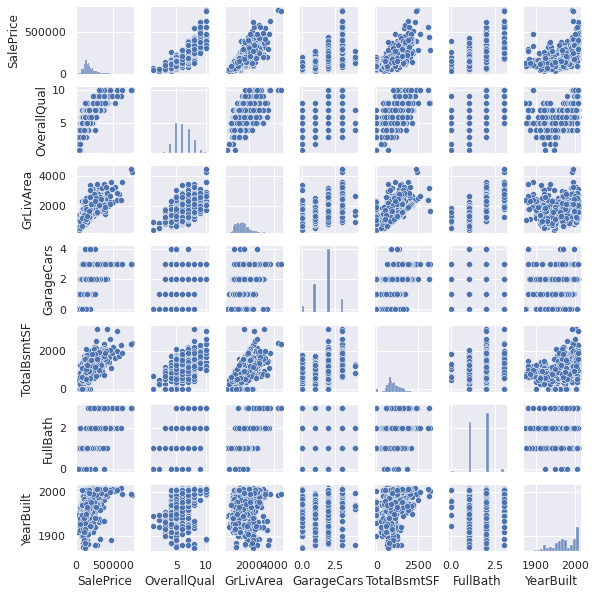

In [67]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 1.2)
plt.show();

We can observe general trend better the quality of the house higher its price\

Higher the price greater the variance

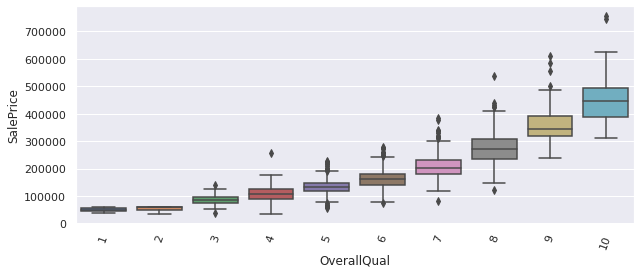

In [68]:
feature = 'OverallQual'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
f, ax = plt.subplots(figsize=(10, 4))
fig = sns.boxplot(x=feature, y="SalePrice", data=data)
plt.xticks(rotation=70);

Now, let's observe general tendency of saleprices over the years

We can see that house prices increase over time

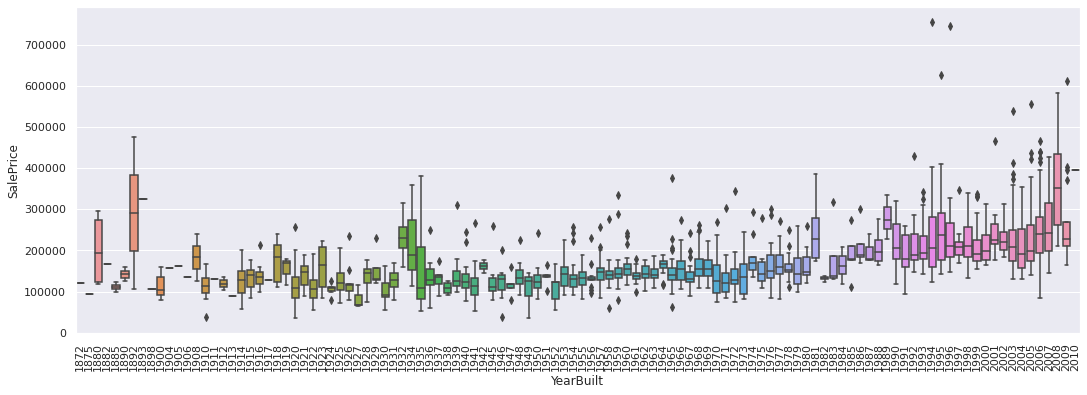

In [69]:
feature = 'YearBuilt'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=feature, y="SalePrice", data=data)
plt.xticks(rotation=90);

## Skewness observation

We would like to fix skewness of our features because model we will be using have an assumption that feature are normally distributed. For higher performance we will convert our distribution to normal.

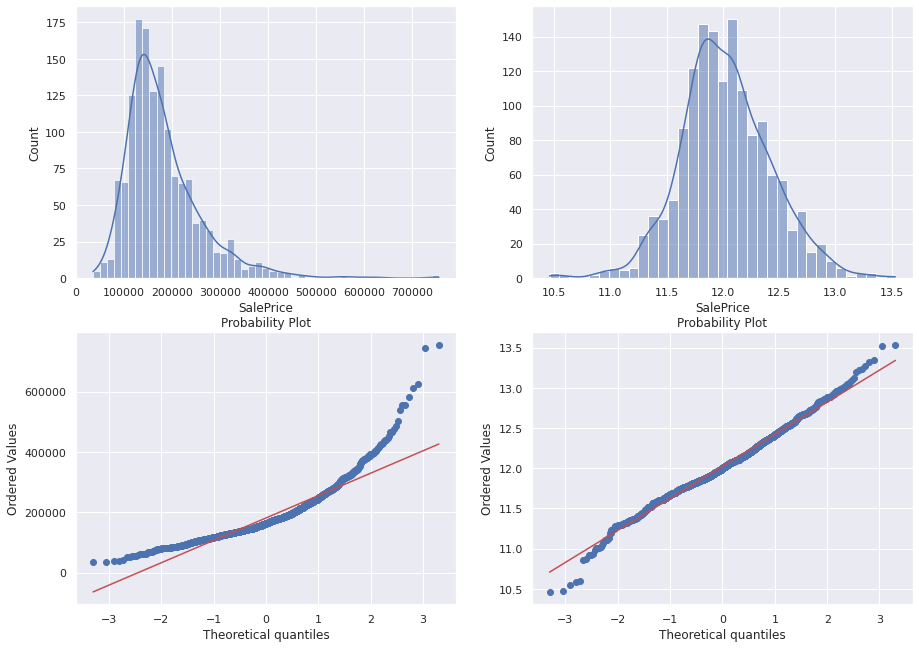

In [70]:
# normalize skewness of the SalePrice feature

# combination of histogram and kdeplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11))

sns.histplot(train['SalePrice'], ax=ax1, kde=True);
sns.histplot(np.log(train['SalePrice']), ax=ax2, kde=True);

# probability plot
stats.probplot(train['SalePrice'], plot=ax3);
stats.probplot(np.log(train['SalePrice']), plot=ax4);

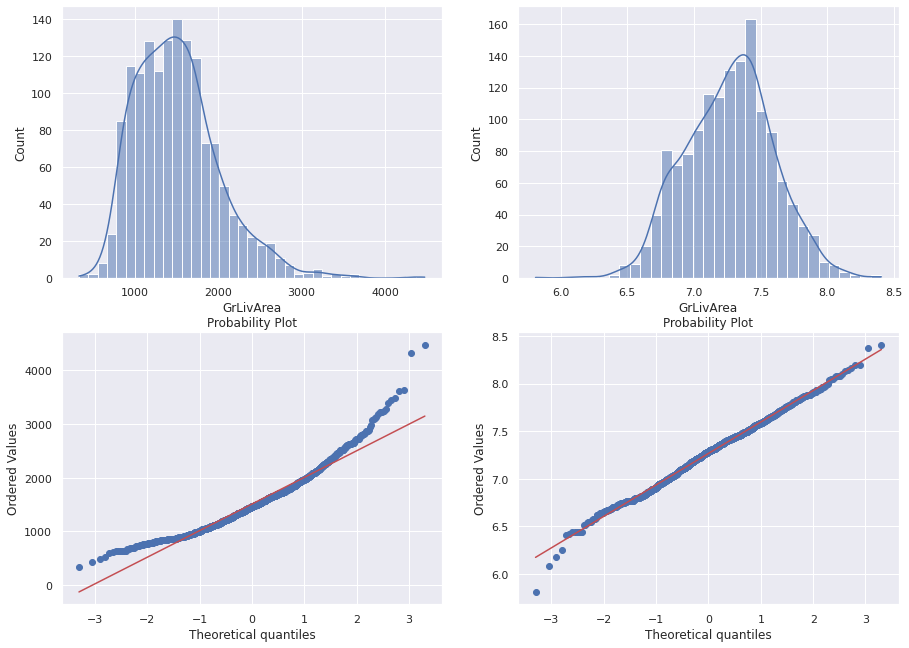

In [71]:
# normalize skewness of the GrLivArea feature
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11))

sns.histplot(train['GrLivArea'], ax=ax1, kde=True);
sns.histplot(np.log(train['GrLivArea']), ax=ax2, kde=True);

stats.probplot(train['GrLivArea'], plot=ax3);
stats.probplot(np.log(train['GrLivArea']), plot=ax4);

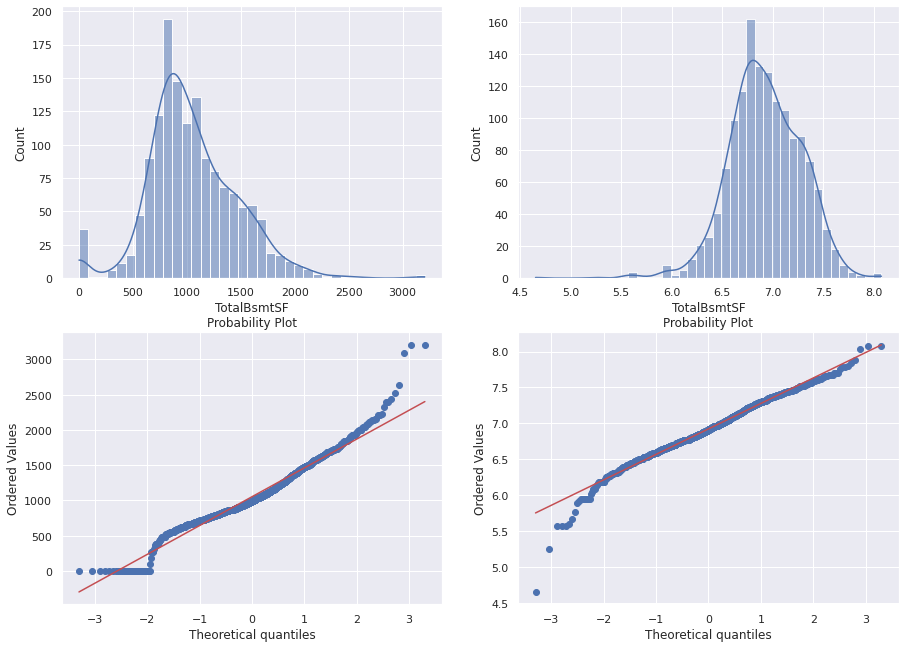

In [72]:
# normalize skewness of the TotalBsmtSF feature
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11))

sns.histplot(train['TotalBsmtSF'], ax=ax1, kde=True);
sns.histplot(np.log(train[train['TotalBsmtSF']>0]['TotalBsmtSF']), ax=ax2, kde=True);

stats.probplot(train['TotalBsmtSF'], plot=ax3);
stats.probplot(np.log(train[train['TotalBsmtSF']>0]['TotalBsmtSF']), plot=ax4);

In [76]:
# move out target feature
train_target = train['SalePrice']
train_data= train.drop(columns=['SalePrice'])

In [79]:
train_test = pd.concat([train_data, test], axis=0, sort=False)

## Fixing skewness

applying things we observed in 1.4 both to train and test dataframes

In [80]:
train_target = np.log(train_target)
train_test['GrLivArea'] = np.log(train_test['GrLivArea'])

train_test['HasBsmt'] = pd.Series(len(train_test['TotalBsmtSF']), index=train_test.index)
train_test['HasBsmt'] = 0 
train_test.loc[train_test['TotalBsmtSF']>0,'HasBsmt'] = 1

train_test.loc[train_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(train_test['TotalBsmtSF'])

In [81]:
train_test.drop(columns=['HasBsmt'], inplace=True)

## Scaling

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = train_test._get_numeric_data().columns.tolist()
train_test.loc[:, num_cols] = scaler.fit_transform(train_test.loc[:, num_cols])

## Feature Engineering

The following features are in fact categorical thus needs conversion to string type

In [83]:
train_test['MSSubClass'] = train_test['MSSubClass'].astype(str)
train_test['OverallCond'] = train_test['OverallCond'].astype(str)
train_test['YrSold'] = train_test['YrSold'].astype(str)
train_test['MoSold'] = train_test['MoSold'].astype(str)

Feature denoting overall square feet in the house

In [84]:
train_test['TotalSF'] = train_test['TotalBsmtSF'] + train_test['1stFlrSF'] + train_test['2ndFlrSF']

## Storing Results

In [85]:
prep_train_data = train_test[0:1458]
prep_test_data = train_test[1458:]

In [86]:
train_target.to_csv('../prep_data/prep_target.csv')
prep_train_data.to_csv('../prep_data/prep_train.csv')
prep_test_data.to_csv('../prep_data/prep_test.csv')